In [23]:
import eelbrain
import eelbrain.datasets._alice
import mne
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import resample

In [2]:
DATA_ROOT = eelbrain.datasets._alice.get_alice_path()

# Define some paths that will be used throughout
STIMULUS_DIR = DATA_ROOT / 'stimuli'
EEG_DIR = DATA_ROOT / 'eeg'

# Load one subject's raw EEG file
SUBJECT = 'S18'
LOW_FREQUENCY = 0.5
HIGH_FREQUENCY = 20

In [3]:
raw = mne.io.read_raw(EEG_DIR / SUBJECT / f'{SUBJECT}_alice-raw.fif', preload=True)

# Filter the raw data to the desired band
raw.filter(LOW_FREQUENCY, HIGH_FREQUENCY, n_jobs=1)

# Interpolate bad channels
# This is not structly necessary for a single subject.
# However, when processing multiple subjects, it will allow comparing results across all sensors.
raw.interpolate_bads()

# Load the events embedded in the raw file as eelbrain.Dataset, a type of object that represents a data-table
events = eelbrain.load.mne.events(raw)
events_no_envelope = eelbrain.load.mne.events(raw)
events_no_onset = eelbrain.load.mne.events(raw)

# Display the events table:
events

#,i_start,trigger,event
0,6495,1,1
1,35304,5,2
2,65752,6,3
3,97408,7,4
4,132429,8,5
5,165593,9,6
6,197508,10,7
7,228988,11,8
8,257678,12,9
9,286316,2,10


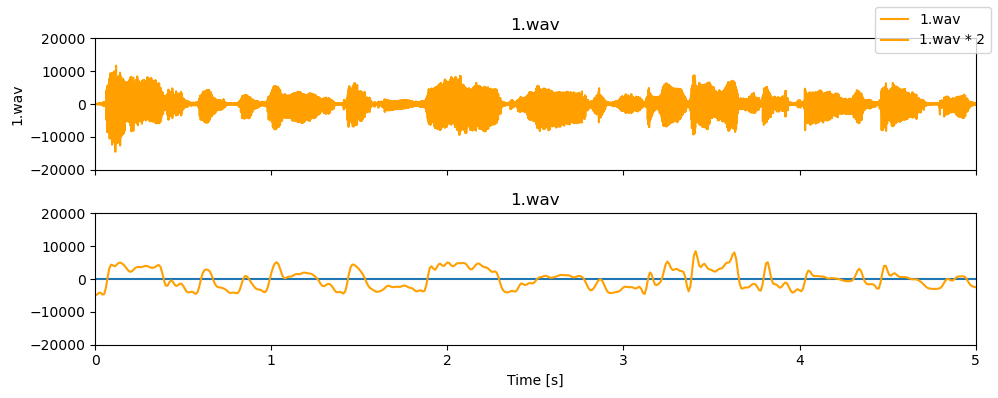

In [4]:
# Load the sound file corresponding to trigger 1
wav = eelbrain.load.wav(STIMULUS_DIR / f'1.wav')

# Compute the acoustic envelope
envelope = wav.envelope()

# Filter the envelope with the same parameters as the EEG data
envelope = eelbrain.filter_data(envelope, LOW_FREQUENCY, HIGH_FREQUENCY, pad='reflect')
envelope = eelbrain.resample(envelope, 100)

# Visualize the first 5 seconds
p = eelbrain.plot.UTS([wav, envelope * 2], axh=2, w=10, columns=1, xlim=5)

# Add y=0 as reference
p.add_hline(0, zorder=0)

In [5]:
envelopes = []
for stimulus_id in events['event']:
    wav = eelbrain.load.wav(STIMULUS_DIR / f'{stimulus_id}.wav')
    envelope = wav.envelope()
    envelope = eelbrain.filter_data(envelope, LOW_FREQUENCY, HIGH_FREQUENCY, pad='reflect')
    envelope = eelbrain.resample(envelope, 100)
    envelopes.append(envelope)

# Add the envelopes to the events table
events['envelope'] = envelopes
events_no_onset['envelope'] = envelopes

# Add a second predictor corresponding to acoustic onsets
events['onsets'] = [envelope.diff('time').clip(0) for envelope in envelopes]
events_no_envelope['onsets'] = [envelope.diff('time').clip(0) for envelope in envelopes]

# Extract the stimulus duration (in seconds) from the envelopes
events['duration'] = eelbrain.Var([envelope.time.tstop for envelope in events['envelope']])
events['eeg'] = eelbrain.load.mne.variable_length_epochs(events, 0, tstop='duration', decim=5, connectivity='auto')

events_no_envelope['duration'] = eelbrain.Var([envelope.time.tstop for envelope in events['envelope']])
events_no_onset['duration'] = eelbrain.Var([envelope.time.tstop for envelope in events['envelope']])
events_no_envelope['eeg'] = eelbrain.load.mne.variable_length_epochs(events, 0, tstop='duration', decim=5, connectivity='auto')
events_no_onset['eeg'] = eelbrain.load.mne.variable_length_epochs(events, 0, tstop='duration', decim=5, connectivity='auto')

In [6]:
# Create decoders for each one
trf_full = eelbrain.boosting('eeg', ['envelope', 'onsets'], 0.175, 0.225, data=events[:11], partitions=5, delta=0.05, test=True)
trf_no_envelope = eelbrain.boosting('eeg', 'onsets', 0.175, 0.225, data=events_no_envelope[:11], partitions=5, delta=0.05, test=True)
trf_no_onset = eelbrain.boosting('eeg', 'envelope', 0.175, 0.225, data=events_no_onset[:11], partitions=5, delta=0.05, test=True)

print("The predictive power of the TRF with all data, TRF with no envelope data and TRF with no onset data are \n" + str(trf_full.proportion_explained.mean()) + "\n" +
str(trf_no_envelope.proportion_explained.mean()) + "\n" + str(trf_no_onset.proportion_explained.mean()) + "\nrespectively.")

The predictive power of the TRF with all data, TRF with no envelope data and TRF with no onset data are 
0.00022723035545545463
-0.00013393529659565728
0.0002130088714554269
respectively.


In [7]:
'''
Based on the above results, I can say that brain activity represents the envelope of acoustic power but not acoustic onsets. This is because
the TRF using only the envelope to predict brain activity almost has the same positive predictive power as the full TRF. On the other hand,
the TRF using only the onset produced a negative value predictive power, meaning that it performs worse!
'''

'\nBased on the above results, I can say that brain activity represents the envelope of acoustic power but not acoustic onsets. This is because\nthe TRF using only the envelope to predict brain activity almost has the same positive predictive power as the full TRF. On the other hand,\nthe TRF using only the onset produced a negative value predictive power, meaning that it performs worse!\n'

In [21]:
# Extract 1D envelope and onset predictor from pickle files
coch_acoustic: eelbrain._data_obj.NDVar = eelbrain.load.unpickle(r"C:\Users\Tyler Lee\Data\Alice\predictors\1~gammatone-1.pickle")
coch_onset: eelbrain._data_obj.NDVar = eelbrain.load.unpickle(r"C:\Users\Tyler Lee\Data\Alice\predictors\1~gammatone-on-1.pickle")

predictor_dir = DATA_ROOT / 'predictors'

envelope_predictors = [
    eelbrain.load.unpickle(predictor_dir / f'{i}~gammatone-1.pickle')
    for i in range(1, 13)
]

onset_predictors = [
    eelbrain.load.unpickle(predictor_dir / f'{i}~gammatone-on-1.pickle')
    for i in range(1, 13)
]

# Combine envelope and onset predictors along a new dimension
# combined_predictors = [
#     eelbrain.concatenate([env, on], dim="predictor_type")
#     for env, on in zip(envelope_predictors, onset_predictors)
# ]

predictors = []
for stimulus_id in events['event']:
    predictor = eelbrain.load.unpickle(predictor_dir / f'{stimulus_id}~gammatone-1.pickle')
    predictor = eelbrain.filter_data(predictor, LOW_FREQUENCY, HIGH_FREQUENCY, pad='reflect')
    predictor = eelbrain.resample(predictor, 100)
    predictors.append(predictor)

events['predictor'] = predictors
events
# print(events['eeg'][1].time.nsamples)
# events['eeg'][1].time.nsamples = events['eeg'][1].time.nsamples - 1
# print(events['eeg'][1].time.nsamples)

#,i_start,trigger,event,envelope,onsets,duration,eeg,predictor
0,6495,1,1,<NDVar '1.wa...,<NDVar '1.wa...,57.54,<NDVar: 61 s...,<NDVar '1.wa...
1,35304,5,2,<NDVar '2.wa...,<NDVar '2.wa...,60.85,<NDVar: 61 s...,<NDVar '2.wa...
2,65752,6,3,<NDVar '3.wa...,<NDVar '3.wa...,63.26,<NDVar: 61 s...,<NDVar '3.wa...
3,97408,7,4,<NDVar '4.wa...,<NDVar '4.wa...,69.99,<NDVar: 61 s...,<NDVar '4.wa...
4,132429,8,5,<NDVar '5.wa...,<NDVar '5.wa...,66.27,<NDVar: 61 s...,<NDVar '5.wa...
5,165593,9,6,<NDVar '6.wa...,<NDVar '6.wa...,63.78,<NDVar: 61 s...,<NDVar '6.wa...
6,197508,10,7,<NDVar '7.wa...,<NDVar '7.wa...,62.9,<NDVar: 61 s...,<NDVar '7.wa...
7,228988,11,8,<NDVar '8.wa...,<NDVar '8.wa...,57.31,<NDVar: 61 s...,<NDVar '8.wa...
8,257678,12,9,<NDVar '9.wa...,<NDVar '9.wa...,57.23,<NDVar: 61 s...,<NDVar '9.wa...
9,286316,2,10,<NDVar '10.w...,<NDVar '10.w...,61.27,<NDVar: 61 s...,<NDVar '10.w...


In [20]:
# for event_no in events['event']:
#     if events['eeg'][event_no].time.nsamples > events['predictor'][event_no].time.nsamples:
#         events['eeg'][event_no].time.nsamples = events['eeg'][event_no].time.nsamples - 1
# events['eeg'][1].time.nsamples = events['eeg'][1].time.nsamples - 1        

trf_coch = eelbrain.boosting('eeg', 'predictor', 0.175, 0.225, data=events[:11], partitions=5, delta=0.05, test=True)
print("The predictive power of the acoustic waveform vs the cochleagram respectively are:\n" + str(trf_no_onset.proportion_explained.mean()) + "\n" + 
     str(trf_coch.proportion_explained.mean()))

ValueError: cannot reshape array of size 371185 into shape (61,6084)